Based on:

P. Donizy, M. Krzyzinski et al. Machine learning models demonstrate that clinicopathologic variables are comparable to gene expression prognostic signature in predicting survival in uveal melanoma. 

European Journal of Cancer, 2022.

paper: https://doi.org/10.1016/j.ejca.2022.07.031

code: https://doi.org/10.24433/CO.0762447.v1

In [65]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from matplotlib.collections import LineCollection
from sksurv.util import Surv

import src

In [21]:
df_train_raw = pd.read_csv('data/uvealmelanoma_ejc2022_train.csv')
df_valid_raw = pd.read_csv('data/uvealmelanoma_ejc2022_valid.csv')

In [22]:
categorical_variables = ["sex",
                         "stage",
                         "tumor.location",
                         "histologic.subtype",               
                         "scleral.infiltration",
                         "invasion.optic.nerve.head",        
                         "extraocular.growth",
                         "necrosis",                         
                         "lymphovascular.invasion",
                         "pigmentation.clinical",            
                         "tumor.shape",
                         "retinal.detachment",               
                         "glaucoma",
                         "clinical.localization",
                         "TIL.pattern",    
                         "TIL.density",
                         "TIM.pattern",    
                         "TIM.density",
                         "pigment.quantity",            
                         "pigment.quality",
                         "nucleoli.size",
                         "hemorrhage",                       
                         "BAP1.mutation",
                         "ciliary.body.infiltration"]

In [23]:
df_train = df_train_raw.dropna().reset_index(drop=True)
X_train = df_train.drop(["os.status", "os", "pfs.status", "pfs"] + categorical_variables, axis=1)
y_train = Surv().from_dataframe("os.status", "os", df_train)

In [24]:
df_valid = df_valid_raw.dropna().reset_index(drop=True).loc[:, pd.Series(np.intersect1d(df_valid_raw.columns.values, df_train_raw.columns.values))]
X_valid = df_valid.drop(["os.status", "os", "pfs.status", "pfs"] + np.intersect1d(df_valid_raw.columns.values, categorical_variables).tolist(), axis=1)
X_valid = X_valid.loc[:, X_train.columns]
y_valid = Surv().from_dataframe("os.status", "os", df_valid)

In [43]:
# model = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=456)
# model = RandomSurvivalForest(n_estimators=100, max_depth=6, random_state=456)
model = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.05, max_depth=4, random_state=456)

In [44]:
model.fit(X_train.values, y_train)

,loss,'coxph'
,learning_rate,0.05
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,4
,min_impurity_decrease,0.0
,random_state,456


In [45]:
print(f'Train score: {model.score(X_train.values, y_train).item():.03f} | Valid score: {model.score(X_valid.values, y_valid).item():.03f}')

Train score: 0.927 | Valid score: 0.758


In [46]:
np.random.seed(456)
explanations_order1 = src.survshapiq(
    model, 
    X_train.values, 
    [X_valid.iloc[[i]] for i in range(0, X_valid.shape[0])], 
    feature_names=X_train.columns,
    n_timepoints=41,
    exact=False, 
    budget=2**X_train.shape[1] if X_train.shape[1] <= 9 else 2**9,
    index="SV",
    approximator="auto",
    max_order=1
)

100%|██████████| 77/77 [33:21<00:00, 25.99s/it]


In [47]:
filename = f'results/uvealmelanoma_explanations_order1_gbs_maxdepth4.pkl'
with open(filename, 'wb') as f:
    pickle.dump(explanations_order1, f)

In [ ]:
filename = f'results/uvealmelanoma_explanations_order1_gbs_maxdepth4.pkl'
with open(filename, 'rb') as f:
    explanations_order1 = pickle.load(f)

In [71]:
timepoints = src.get_evenly_spaced_integers(model.unique_times_, 41)

In [125]:
df_plot1 = pd.concat([explanations_order1[i].assign(time=timepoints, id=i) for i in range(X_valid.shape[0])])
df_plot1 = pd.melt(df_plot1, id_vars=['time', 'id'], var_name="feature")

In [126]:
df_plot1.feature.unique()

array(['mean.nuclear.area', 'mean.nucleus.perimeter',
       'mean.nucleus.circularity', 'mean.nucleus.max.caliper',
       'mean.nucleus.min.caliper', 'age', 'largest.basal.tumor.diameter',
       'tumor.thickness', 'mitotic.rate'], dtype=object)

In [127]:
df_plot1.feature = df_plot1.feature.map({
    'mean.nuclear.area': 'nuclear_area', 
    'mean.nucleus.perimeter': 'nucleus_perimeter',
    'mean.nucleus.circularity': 'nucleus_circularity',
    'mean.nucleus.max.caliper': 'nucleus_max_caliper',
    'mean.nucleus.min.caliper': 'nucleus_min_caliper',
    'age': 'age',
    'largest.basal.tumor.diameter': 'max_tumor_diameter',
    'tumor.thickness': 'tumor_thickness',
    'mitotic.rate': 'mitotic_rate'
})

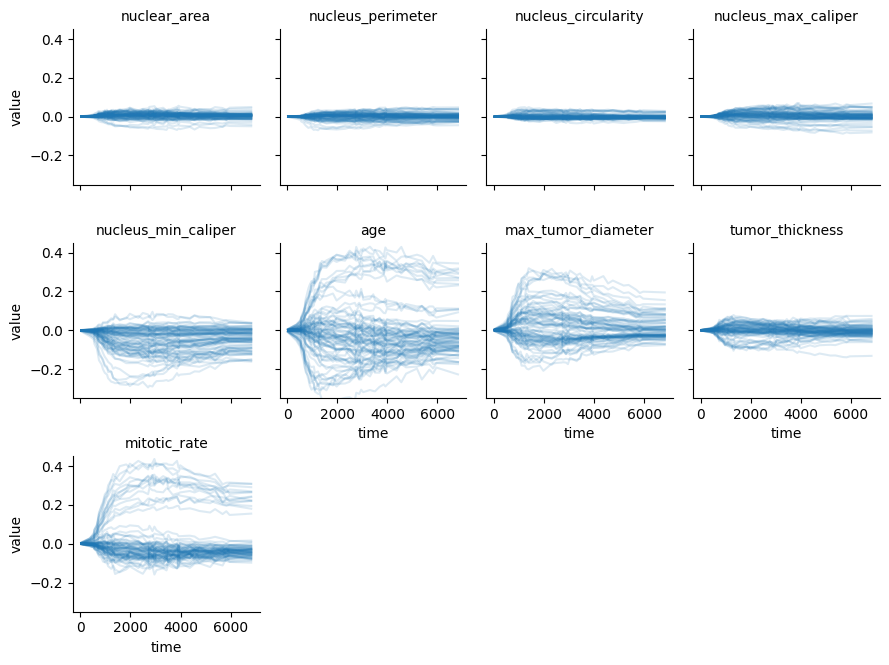

In [128]:
ax = sns.relplot(
    df_plot1, 
    x="time", y="value", col="feature", kind="line", units="id", 
    estimator=None, alpha=0.15, 
    height=2.25,
    aspect=1,
    col_wrap=4
)
ax.set_titles(col_template="{col_name}")
# ax.set(xscale='log')
ax.set(ylim=(-0.35, 0.45))
plt.tight_layout()
plt.savefig(f'results/uvealmelanoma_order1_gbs_maxdepth4.png', bbox_inches="tight")

In [129]:
df_plot1 = df_plot1.assign(color=pd.concat([X_valid.iloc[:, i].repeat(41) for i in range(X_valid.shape[1])]).values)

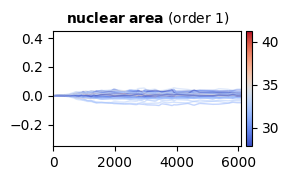

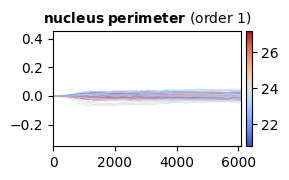

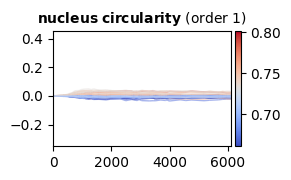

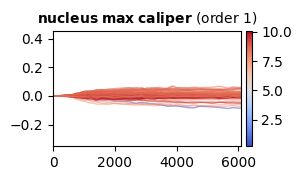

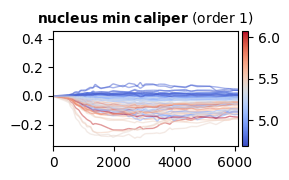

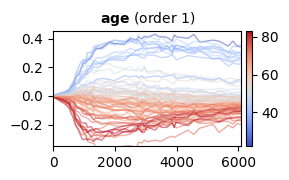

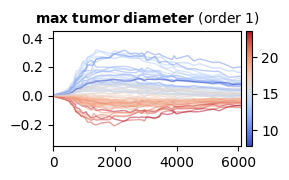

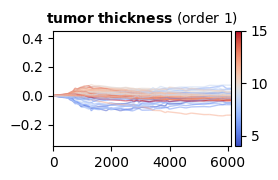

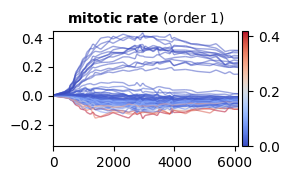

In [136]:
for feature_name in df_plot1.feature.unique():
    temp = df_plot1[df_plot1.feature == feature_name]
    fig, ax = plt.subplots(figsize=(3, 1.90))

    CMAP = "coolwarm"

    for id_val in temp.id.unique():
        line_data = temp[temp.id == id_val].sort_values(by="time")
        x = line_data["time"].values
        y = line_data["value"].values
        c = line_data["color"].values

        # Create line segments with color
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(
            segments,
            cmap=CMAP, # coolwarm
            norm=plt.Normalize(temp.color.min(), temp.color.max()),
            array=c[:-1],  # color values
            linewidth=1,
            alpha=0.5
        )
        ax.add_collection(lc)

    ax.set_xlim(0, 6100)
    ax.set_ylim(-0.35, 0.45)
    ax.set_title("$\mathbf{" + str(feature_name).replace("_", "\;") + "}$ (order 1)", fontsize=10)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(temp.color.quantile(0.00), temp.color.quantile(0.95), clip=True))
    sm.set_array([])  # required for colorbar
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    # cbar.set_label("color value")
    plt.tight_layout()
    plt.savefig(f'results/um_order1_global_{feature_name}.pdf', bbox_inches="tight", pad_inches=0.01)
    # plt.close()

### Order 2

In [55]:
np.random.seed(456)
explanations_order2 = src.survshapiq(
    model, 
    X_train.values, 
    [X_valid.iloc[[i]] for i in range(0, X_valid.shape[0])], 
    feature_names=X_train.columns,
    n_timepoints=41,
    exact=False, 
    budget=2**X_train.shape[1] if X_train.shape[1] <= 9 else 2**9,
    index="k-SII",
    approximator="auto",
    max_order=2
)

100%|██████████| 77/77 [33:00<00:00, 25.72s/it]


In [56]:
filename = f'results/uvealmelanoma_explanations_order2_gbs_maxdepth4.pkl'
with open(filename, 'wb') as f:
    pickle.dump(explanations_order2, f)

In [ ]:
filename = f'results/uvealmelanoma_explanations_order2_gbs_maxdepth4.pkl'
with open(filename, 'rb') as f:
    explanations_order2 = pickle.load(f)

In [57]:
df_plot2 = pd.concat([explanations_order2[i].assign(time=timepoints, id=i) for i in range(X_valid.shape[0])])
df_plot2 = pd.melt(df_plot2, id_vars=['time', 'id'], var_name="feature") #, 'treatment'])

In [58]:
df_plot2.feature = df_plot2.feature.str.replace("*", "\n *")

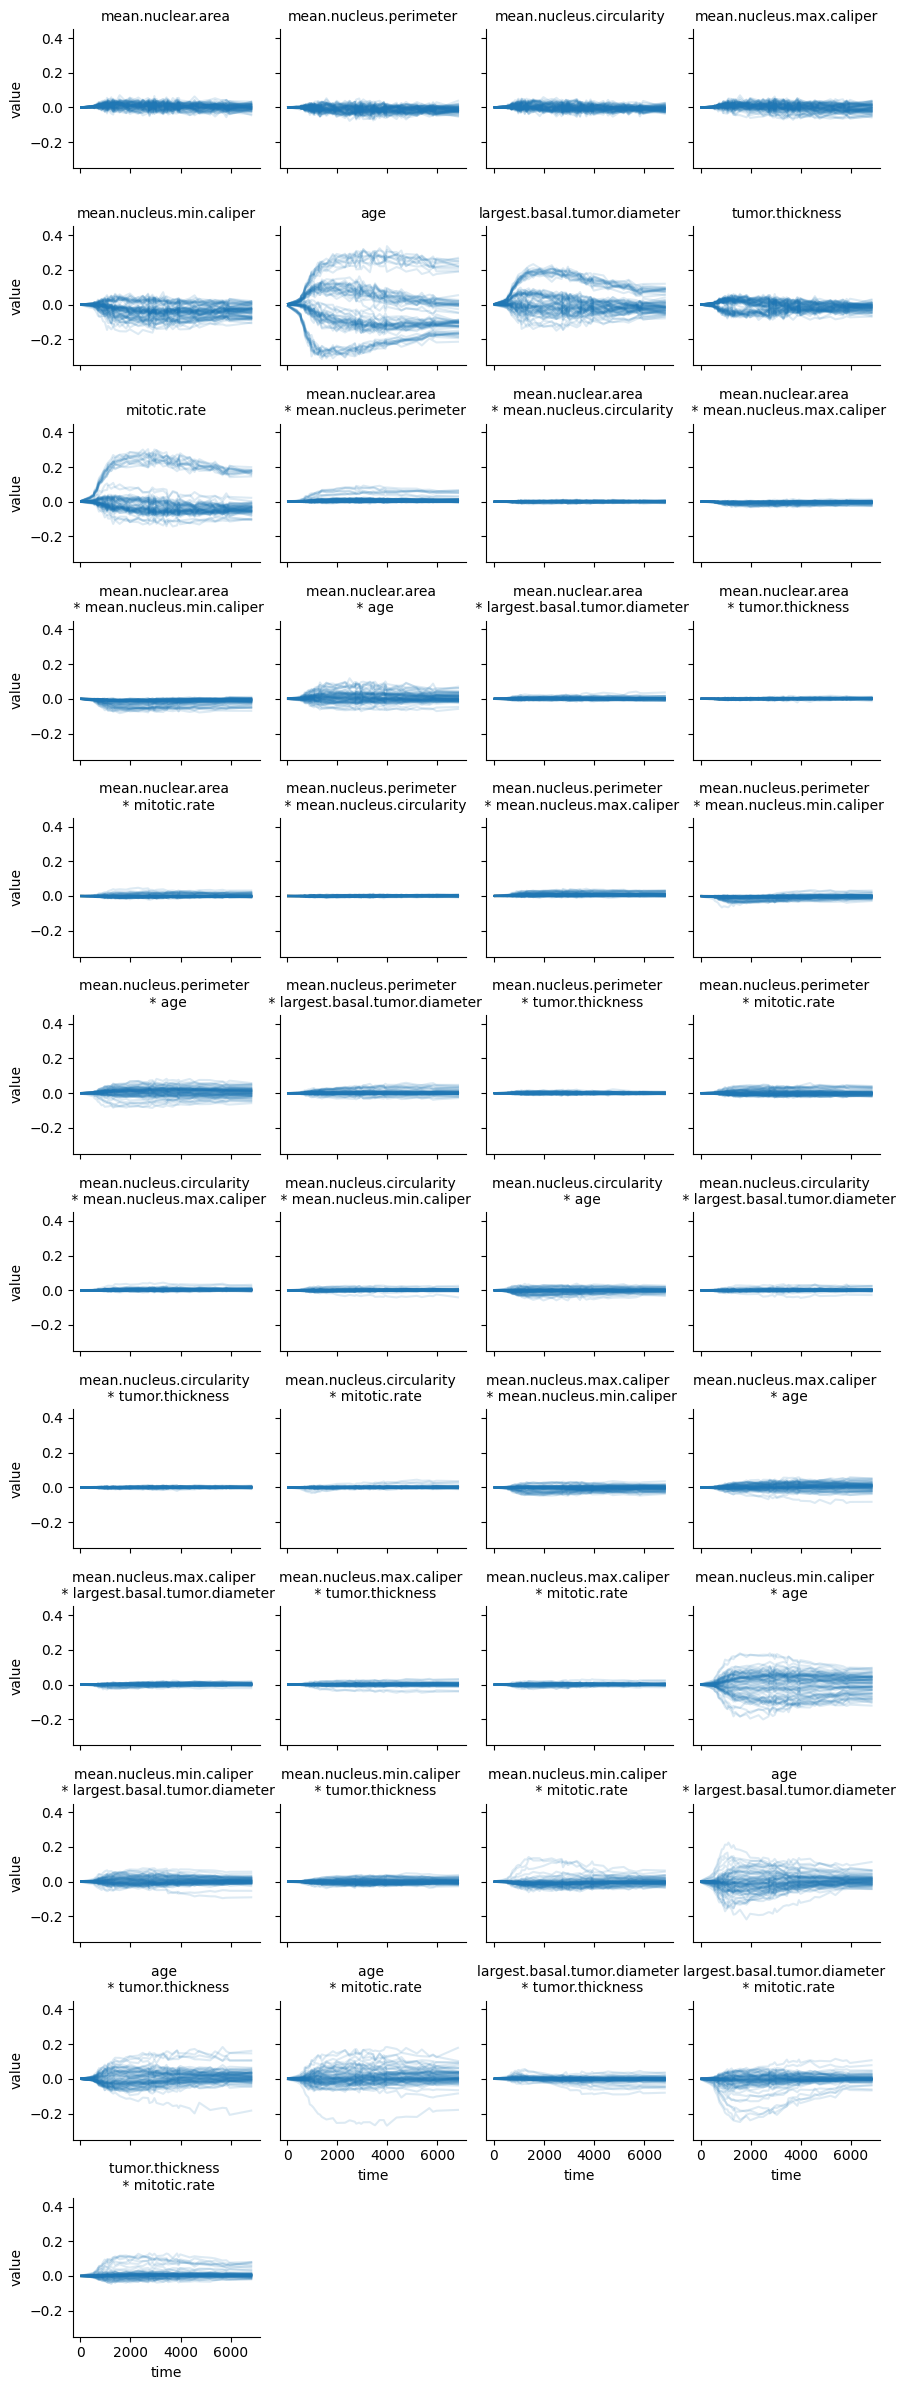

In [60]:
ax = sns.relplot(
    df_plot2, 
    x="time", y="value", col="feature", kind="line", units="id", 
    estimator=None, alpha=0.15, 
    height=2,
    aspect=1.125,
    col_wrap=4
)
ax.set_titles(col_template="{col_name}")
ax.set(ylim=(-0.35, 0.45))
plt.tight_layout()
plt.savefig(f'results/uvealmelanoma_order2_gbs_maxdepth4.png', bbox_inches="tight")
# plt.clf()

In [137]:
df_plot2_attribution = df_plot2.loc[df_plot2.feature.isin(X_valid.columns), :]
df_plot2_attribution = df_plot2_attribution.assign(color=pd.concat([X_valid.iloc[:, i].repeat(41) for i in range(X_valid.shape[1])]).values)

df_plot2_attribution.feature = df_plot2_attribution.feature.map({
    'mean.nuclear.area': 'nuclear_area', 
    'mean.nucleus.perimeter': 'nucleus_perimeter',
    'mean.nucleus.circularity': 'nucleus_circularity',
    'mean.nucleus.max.caliper': 'nucleus_max_caliper',
    'mean.nucleus.min.caliper': 'nucleus_min_caliper',
    'age': 'age',
    'largest.basal.tumor.diameter': 'max_tumor_diameter',
    'tumor.thickness': 'tumor_thickness',
    'mitotic.rate': 'mitotic_rate'
})

df_plot2_interaction = df_plot2.loc[~df_plot2.feature.isin(X_valid.columns), :]

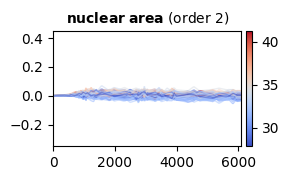

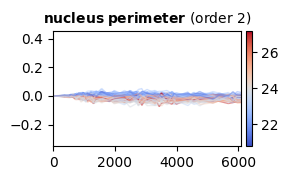

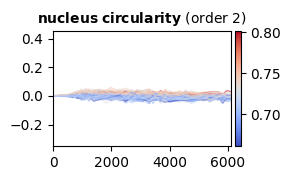

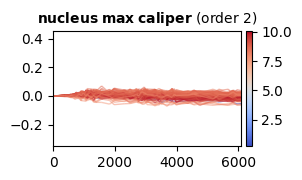

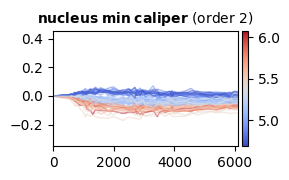

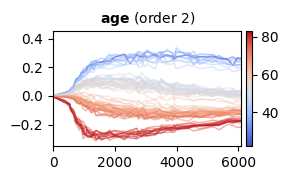

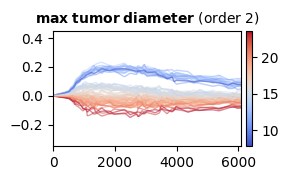

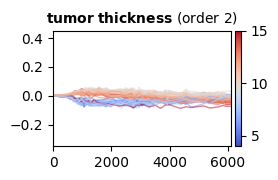

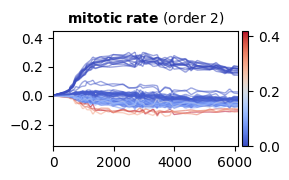

In [138]:
for feature_name in df_plot2_attribution.feature.unique():
    temp = df_plot2_attribution[df_plot2_attribution.feature == feature_name]
    fig, ax = plt.subplots(figsize=(3, 1.90))

    CMAP = "coolwarm"

    for id_val in temp.id.unique():
        line_data = temp[temp.id == id_val].sort_values(by="time")
        x = line_data["time"].values
        y = line_data["value"].values
        c = line_data["color"].values

        # Create line segments with color
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(
            segments,
            cmap=CMAP, # coolwarm
            norm=plt.Normalize(temp.color.min(), temp.color.max()),
            array=c[:-1],  # color values
            linewidth=1,
            alpha=0.5
        )
        ax.add_collection(lc)

    ax.set_xlim(0, 6100)
    ax.set_ylim(-0.35, 0.45)
    ax.set_title("$\mathbf{" + str(feature_name).replace("_", "\;") + "}$ (order 2)", fontsize=10)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=CMAP, norm=plt.Normalize(temp.color.quantile(0.00), temp.color.quantile(0.95), clip=True))
    sm.set_array([])  # required for colorbar
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    # cbar.set_label("color value")
    plt.tight_layout()
    plt.savefig(f'results/um_order2_global_{feature_name}.pdf', bbox_inches="tight", pad_inches=0.01)
    # plt.close()

In [ ]:
for feature_name in ['karnof * cd4', 'karnof * age', 'cd4 * age', 'cd4 * priorzdv']:
    temp = df_plot2_interaction[df_plot2_interaction.feature == feature_name]

    if feature_name == 'karnof * cd4':
        high_karnof = (X_valid.loc[:, "karnof"].repeat(35) >= X_valid.loc[:, "karnof"].median()) 
        high_cd4 = (X_valid.loc[:, "cd4"].repeat(35) >= 50)
        tcolor = np.empty(temp.shape[0], dtype=np.dtypes.StringDType())
        tcolor[high_karnof & high_cd4] = "high * high"
        tcolor[high_karnof & ~high_cd4] = "high * low"
        tcolor[~high_karnof & high_cd4] = "low * high"
        tcolor[~high_karnof & ~high_cd4] = "low * low"
        temp = temp.assign(color=tcolor)

    if feature_name == 'karnof * age':
        high_karnof = (X_explain.loc[:, "karnof"].repeat(35) >= X_explain.loc[:, "karnof"].median()) 
        high_age = (X_explain.loc[:, "age"].repeat(35) >= X_explain.loc[:, "age"].median())
        tcolor = np.empty(temp.shape[0], dtype=np.dtypes.StringDType())
        tcolor[high_karnof & high_age] = "high * high"
        tcolor[high_karnof & ~high_age] = "high * low"
        tcolor[~high_karnof & high_age] = "low * high"
        tcolor[~high_karnof & ~high_age] = "low * low"
        temp = temp.assign(color=tcolor)

    if feature_name == 'cd4 * age':
        high_cd4 = (X_explain.loc[:, "cd4"].repeat(35) >= 50)
        high_age = (X_explain.loc[:, "age"].repeat(35) >= X_explain.loc[:, "age"].median())
        tcolor = np.empty(temp.shape[0], dtype=np.dtypes.StringDType())
        tcolor[high_cd4 & high_age] = "high * high"
        tcolor[high_cd4 & ~high_age] = "high * low"
        tcolor[~high_cd4 & high_age] = "low * high"
        tcolor[~high_cd4 & ~high_age] = "low * low"
        temp = temp.assign(color=tcolor)

    if feature_name == 'cd4 * priorzdv':
        high_cd4 = (X_explain.loc[:, "cd4"].repeat(35) >= 50)
        high_priorzdv = (X_explain.loc[:, "priorzdv"].repeat(35) >= X_explain.loc[:, "priorzdv"].median())
        tcolor = np.empty(temp.shape[0], dtype=np.dtypes.StringDType())
        tcolor[high_cd4 & high_priorzdv] = "high * high"
        tcolor[high_cd4 & ~high_priorzdv] = "high * low"
        tcolor[~high_cd4 & high_priorzdv] = "low * high"
        tcolor[~high_cd4 & ~high_priorzdv] = "low * low"
        temp = temp.assign(color=tcolor)

    fig, ax = plt.subplots(figsize=(3, 1.75))

    for group, group_data in temp.groupby("color"):
        for id_val in group_data.id.unique():
            line_data = group_data[group_data.id == id_val].sort_values("time")
            x = line_data["time"].values
            y = line_data["value"].values
            ax.plot(x, y, color=palette[group], alpha=0.5, linewidth=0.75)

    ax.set_xlim(0, 305)
    ax.set_ylim(-0.22, 0.13)
    feat1 = feature_name.split(" * ")[0]
    feat2 = feature_name.split(" * ")[1]
    ax.set_title("$\mathbf{" + feat1 + "} \\times \mathbf{" + feat2 + "}$")

    # Label setup
    # if feature_name == "karnof * cd4":
    #     ax.set_xlabel('Time')
    #     ax.set_ylabel('Attribution')
    # if feature_name == "cd4 * priorzdv":
    #     ax.set_xlabel('Time')
    #     ax.set_ylabel(' ')

    # Add legend
    handles = [plt.Line2D([0], [0], color=color, lw=2, label=label) for label, color in palette.items()]
    ax.legend(
        handles=handles, 
        loc="upper center",
        bbox_to_anchor=(0.5, 0.35),  # Adjust position below plot
        ncol=2,  # Spread out horizontally
        frameon=False,
        fontsize=9,
        columnspacing=1,
        labelspacing=0.2
    )

    # Save
    plt.savefig(f'results/actg_order2_global_{feature_name.replace(" * ", "-")}_v1.pdf', bbox_inches="tight", pad_inches=0.01)
    # plt.close()